# 인구 소득 예측 경진대회

## 데이터 불러오기

In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [367]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

In [2]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [184]:
sns.set_theme()

`-` SEED 앙상블 해보자

In [5]:
SEED = 22

In [4]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\인구-소득-예측')

In [345]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

|변수 이름 |세부 사항 |
|:-:|:-:|
|id | 샘플 아이디|
|age | 나이|
|workclass | 일 유형|
|fnlwgt | CPS(Current Population Survey) 가중치|
|education | 교육수준|
|education.num | 교육수준 번호(클수록 높은 학위)|
|marital.status | 결혼 상태|
|occupation| 직업|
|relationship | 가족관계|
|race | 인종|
|sex |성별|
|capital.gain | 자본 이익|
|capital.loss | 자본 손실|
|hours.per.week |주당 근무시간|
|native.country | 본 국적|
|target | 소득(0 = <=50K, 1 = >50K)|

In [346]:
df.drop('id', axis=1, inplace=True)

In [347]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

`-` `workclass`, `occupation`, `native.country` 변수에 결측치가 존재한다

## 데이터 전처리

`-` 분석의 편의성을 위해 변수명의 `.`을 `_`으로 바꾸겠다

In [348]:
def replace_dot2underbar(df) -> None:
    """데이터프레임의 변수명에 포함된 .(dot)을 _(underbar)로 변경한다"""
    df.rename(columns = dict(zip(df.columns, [column.replace('.', '_') for column in df.columns])), inplace=True) 

In [349]:
replace_dot2underbar(df)

In [350]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'target'],
      dtype='object')

`-` 잘 바뀌었다

`-` 이제 변수 타입을 확인하자

In [351]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
target             int64
dtype: object

`-` 상식에 벗어나는 타입을 가진 변수는 없다

`-` 그런데 수치로 코딩된 범주형 변수가 있어서 일일이 바꿔주자

In [352]:
df['education_num'] = df['education_num'].astype('str')
df['target'] = df['target'].map({1:'>50K', 0:'<=50K'})

`-` 오브젝트 타입 변수의 유니크한 값의 개수를 확인하자

In [353]:
df.dtypes[df.dtypes == 'object']

workclass         object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
native_country    object
target            object
dtype: object

## 범주형 변수 시각화

In [355]:
def show_unique_counts(df_: pd.DataFrame, target: str) -> None:
    """ df의 변수 중에서 범주형 변수의 unique한 값의 개수를 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna()
    ## len(df.columns[df.dtypes == 'object'])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## 결과값이 10이므로 5 X 2 크기의 figure를 만들자
    row, column = 5, 2
    fig, axs = plt.subplots(row, column, figsize=(14, 28))
    features = df.columns[df.dtypes == 'object']
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        sns.countplot(data=df, y=feature, hue=target, order=df[feature].value_counts().index, dodge=False, ax=ax)
    
    del df ## 안해도 되나?
    fig.suptitle("Categorical feature's Unique Counts\n", x=0.56, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

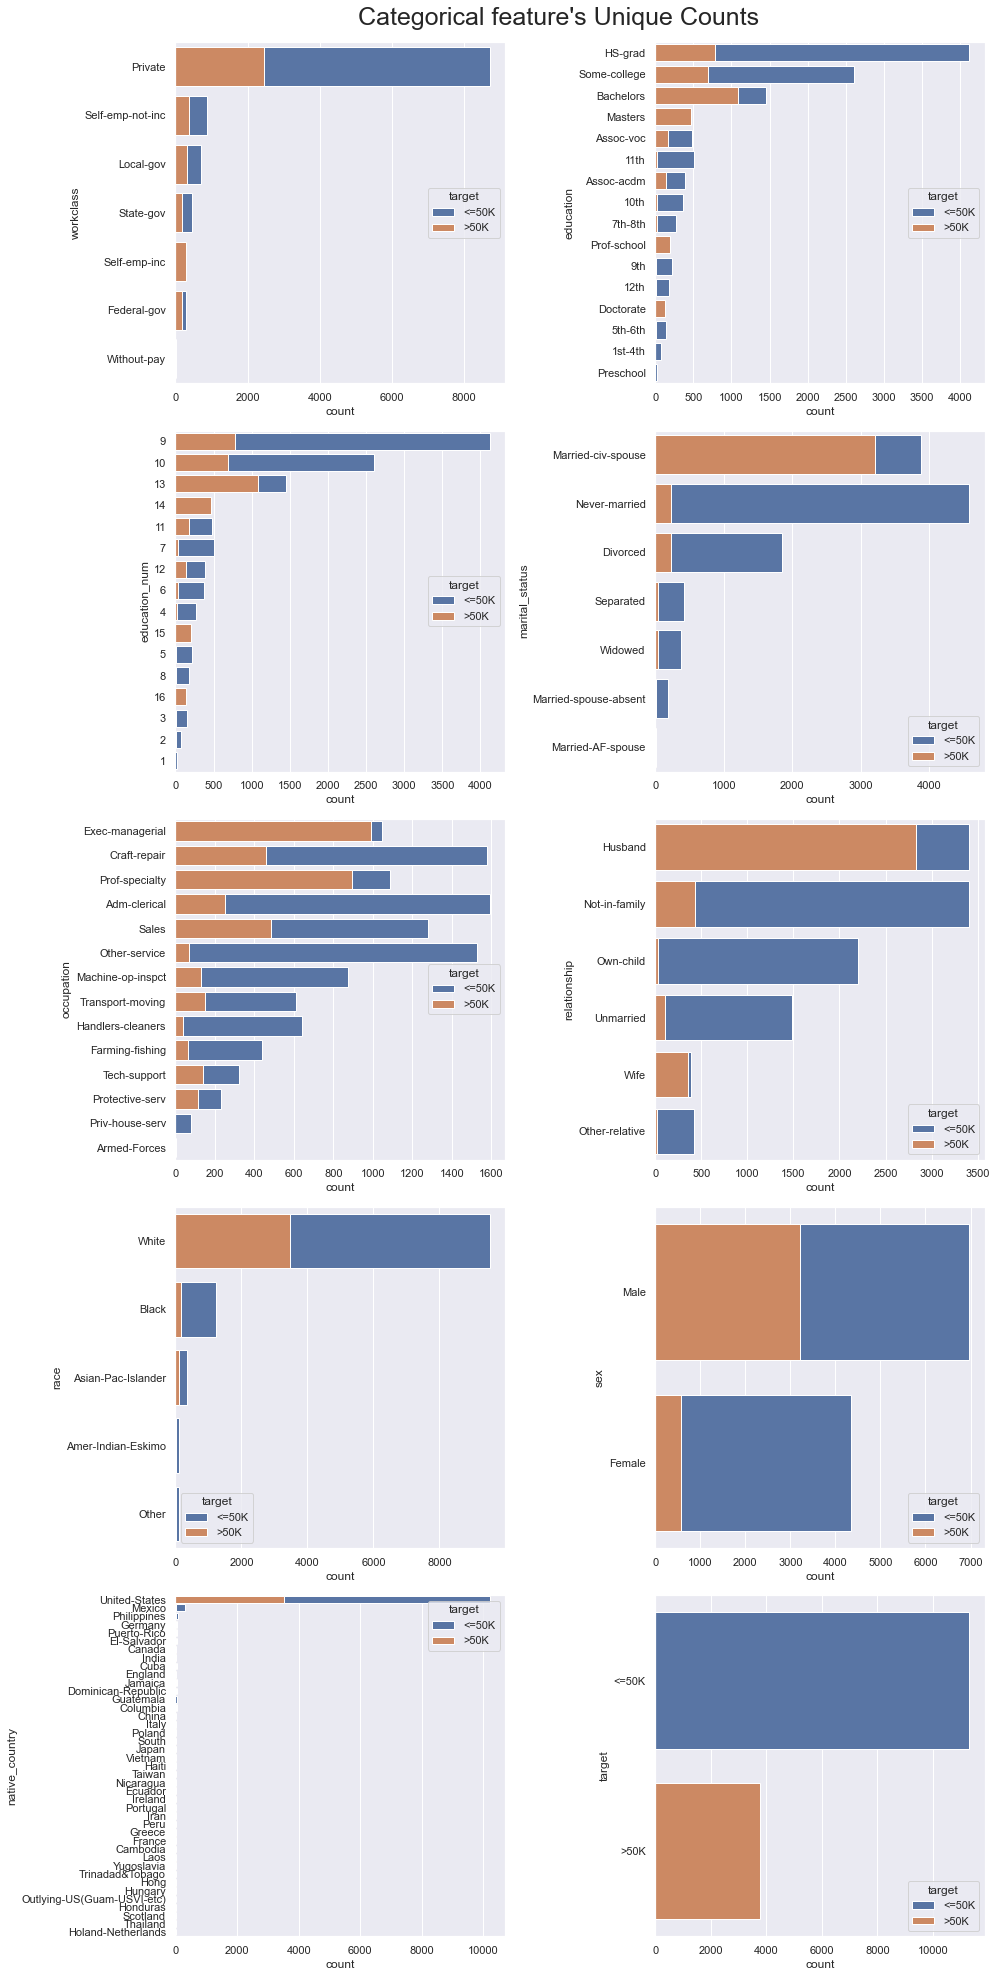

In [356]:
show_unique_counts(df, 'target')

`-` 막대그래프는 count 값을 기준으로 오름차순 정렬됐다(안된건 뭐지?, $y$축을 잘 확인하자)

`-` 미국인 대상으로 조사한 거라 `native_country` 변수의 대부분이 United-States이다

`-` 3개 범주정도만 막대그래프가 보이고 나머지는 상대적으로 너무 적은 나머지 보이지도 않는다...

`-` 소득 범주인 `>50K`과 `<=50K`의 비율 차이가 많이 나는 피쳐의 범주가 존재한다(예컨대 교육번호 피쳐의 $13$, $14$) 

`-` 나중에 수치로 변환할 때 `Other`로 인코딩하는 것도 고려하자

`-` 소득이 50K보다 작은 사람이 50K보다 많은 사람의 3배이다(불균형 클래스)

## 양적 변수 시각화

`-` 소득 범주에 따른 box plot을 그려보자

In [357]:
def show_boxplot(df_: pd.DataFrame, target: str) -> None:
    """ target 범주에 따른 양적 변수의 분포를 박스 플랏을 사용해 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna()
    ## len(df.columns[(df.dtypes == float) | (df.dtypes == np.int64)])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## 결과값이 5이므로 2 X 3 크기의 figure를 만들자
    row, column = 2, 3
    fig, axs = plt.subplots(row, column, figsize=(16, 12))
    features = df.columns[(df.dtypes == float) | (df.dtypes == np.int64)]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        sns.violinplot(data=df, y=feature, x=target, ax=ax)
        
    fig.suptitle("Box Plot\n", fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

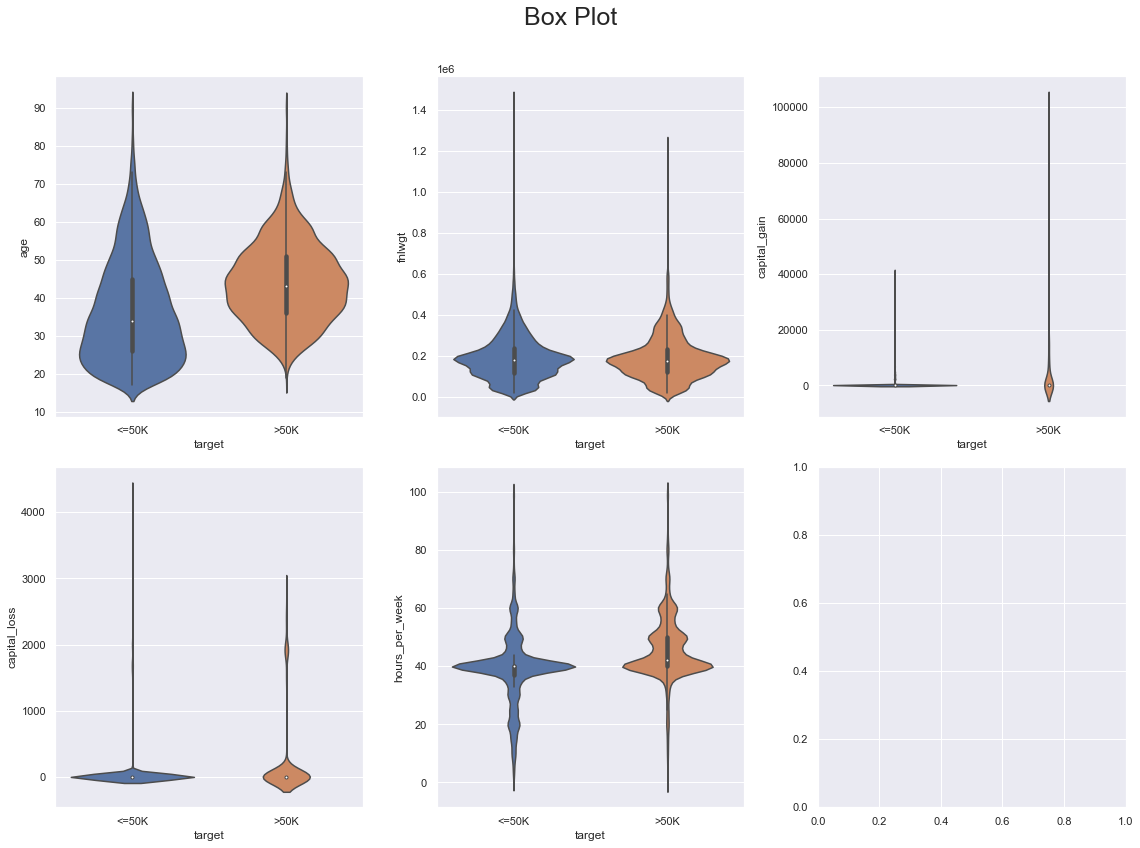

In [359]:
show_boxplot(df, 'target')

`-` 수입이 50K 이상인 사람이 평균적으로 나이가 더 많다

`-` `fnlwgt`은 수입과 관계가 없어보인다

`-` `capital_gain`과 `capital_loss`는 대부분 $0$에 값이 쏠려있다

`-` 그래서 둘다 꼬리가 긴 분포인데 자본 이익은 수입이 50K 이상인 사람들 분포의 꼬리가 더 길고

`-` 자본 손실은 수입이 50K 이하인 사람들 분포의 꼬리가 더 길다

`-` 수입이 50K 이상인 집단들의 자본 손실 분포를 보면 $2000$ 부근에 데이터가 좀 있는 것으로 보인다(why?)

`-` `hours_per_week`의 분포는 두 집단이 비슷한데 수입이 50K 이상인 집단이 조금 더 일을 많이 하는 경향이 있다

<AxesSubplot:>

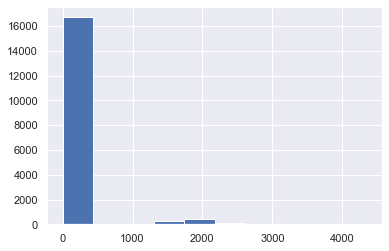

In [360]:
df['capital_loss'].hist()

`-` 신기한 분포이다...

In [361]:
df['captital_loss_approx2000'] = 'No' ## 이런거 변수명 어떻게 지음...

In [362]:
df.loc[(df['capital_loss'] >= 1500) & (df['target'] == '>50K') & (df['capital_loss'] < 2300), 'captital_loss_approx2000'] = 'Yes'

`-` 확인해봤는데 잘 모르겠다

`-` 원래의 분포와 비슷하게 생겼다

In [366]:
df.drop('captital_loss_approx2000', axis=1, inplace=True)